In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

# Step-1: run TD query and download data to local

In [11]:
query1 = '''
-- time range from 2019-08-12 to 2019-09-05
-- pull the position performance and metrics data
select pos, source_type, tid, is_pb,
       sum(impression) as total_impression, 
       sum(gmv) as total_gmv, 
       sum(add_to_cart) as total_addtocart_freq,
       sum(transaction) as total_transaction,
       sum(click_frontend) as total_click_frontend, 
       sum(click_backend) as total_click_backend
from search.daily_feed_position_metrics
where date_str >= "2019-07-01" 
      and date_str <= "2019-09-06"
--      and is_pb = 0
      and source_type IN ('tabbed_feed','search','latest')
      and invalid_session != 1
group by pos, source_type, tid, is_pb
'''

query2 = '''
-- pull EPC product data
select 
--  distinct 
--  td_time_format(td_date_trunc('month', cast(time as bigint)), 'yyyy-MM-dd') as product_month,
  product_id,
  count(product_id) as freq
from 
  sweeper.epc_product_warehouse_status 
where 
  (next_east = 'true' or next_south = 'true' or cur_south = 'true' or cur_east='true')
and
  td_time_range(time, '2019-07-01', NULL,'PDT')
group by product_id
'''

query3 = '''
-- pull data for impression logs
select td_time_format(td_date_trunc('month', cast(show_time as bigint)), 'yyyy-MM-dd') as impression_day,
       cid,
       boost_source,
       tid,
       category_id,
       feed_id,
       client,
       country_code,
       pos,
       count(request_id) as impression
from product_boost.daily_impression_truelog
where td_time_range(show_time, '2019-07-01', NULL,'PDT')
      and likely_bot = 'false'
group by 1,2,3,4,5,6,7,8,9
'''

In [12]:
!pwd

/Users/zzhang/Desktop/version_control/EPC_prod_boost


In [14]:
df_imp_epc = pd.read_csv("/Users/zzhang/Desktop/impression_epc.csv")

In [16]:
df_pos = pd.read_csv("/Users/zzhang/Desktop/position_metrics.csv")
df_pos.head(5)

,pos,source_type,tid,is_pb,total_impression,total_gmv,total_addtocart_freq,total_transaction,total_click_frontend,total_click_backend
0,0,latest,266,0,75096941,684218.105115,465197.0,92852.0,3439914.0,3555531.0
1,0,latest,266,1,22152879,203114.506346,100086.0,15597.0,1020232.0,1019109.0
2,0,latest,1713,0,152524,725.755701,486.0,100.0,3341.0,3557.0
3,0,latest,1713,1,48401,37.469825,67.0,7.0,737.0,766.0
4,0,others,266,0,6,NaN,NaN,NaN,NaN,NaN


In [18]:
df_imp_epc.describe()

,boost_source,tid,pos,impression,epc_impression
count,7338830.0,2.540174e+07,2.540174e+07,2.540174e+07,2.540174e+07
mean,3.0,1.502786e+03,9.290895e+02,1.478410e+02,7.206347e+01
std,0.0,1.053637e+03,1.188282e+03,5.465765e+03,2.833918e+03
min,3.0,5.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.0,1.583000e+03,1.450000e+02,1.000000e+00,0.000000e+00
50%,3.0,1.713000e+03,4.960000e+02,2.000000e+00,1.000000e+00
75%,3.0,1.713000e+03,1.255000e+03,7.000000e+00,3.000000e+00
max,3.0,3.060400e+04,1.673900e+04,7.096489e+06,3.904060e+06


In [20]:
df_imp_epc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25401740 entries, 0 to 25401739
Data columns (total 9 columns):
boost_source      float64
tid               int64
category_id       object
feed_id           object
client            object
country_code      object
pos               int64
impression        int64
epc_impression    int64
dtypes: float64(1), int64(4), object(4)
memory usage: 1.7+ GB


In [28]:
df_imp_epc.shape

(25401740, 9)

In [29]:
df_imp_epc.head(5)

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression
0,NaN,5,NaN,NaN,NaN,AL,1,4,2
1,NaN,5,NaN,NaN,NaN,AL,17,4,2
2,NaN,5,NaN,NaN,NaN,AL,21,4,4
3,NaN,5,NaN,NaN,NaN,AR,39,112,37
4,NaN,5,NaN,NaN,NaN,AR,43,110,37


# Step-2: Prepare the data

In [31]:
def imp_category(tid):
    if (tid in [234,15,235]):
        imp_category = 'search'
    elif (tid in [1713,266,1630,230,352,20023]):
        imp_category = 'feed'
    else:
        imp_category = 'irrelative'
    return imp_category

In [34]:
df_imp_epc['imp_category'] = df_imp_epc['tid'].apply(imp_category)
df_imp_epc.head()

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression,imp_category
0,NaN,5,NaN,NaN,NaN,AL,1,4,2,irrelative
1,NaN,5,NaN,NaN,NaN,AL,17,4,2,irrelative
2,NaN,5,NaN,NaN,NaN,AL,21,4,4,irrelative
3,NaN,5,NaN,NaN,NaN,AR,39,112,37,irrelative
4,NaN,5,NaN,NaN,NaN,AR,43,110,37,irrelative


In [41]:
def rank_category(pos):
    if (pos >=0 and pos <=100):
        rank_category = 'Good'
    elif (pos >=101 and pos <=500):
        rank_category = 'OK'
    else:
        rank_category = 'Not_good'
    return rank_category

In [42]:
df_imp_epc['rank_category'] = df_imp_epc['pos'].apply(rank_category)
df_imp_epc.head()

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression,imp_category,rank_category
0,NaN,5,NaN,NaN,NaN,AL,1,4,2,irrelative,Good
1,NaN,5,NaN,NaN,NaN,AL,17,4,2,irrelative,Good
2,NaN,5,NaN,NaN,NaN,AL,21,4,4,irrelative,Good
3,NaN,5,NaN,NaN,NaN,AR,39,112,37,irrelative,Good
4,NaN,5,NaN,NaN,NaN,AR,43,110,37,irrelative,Good


In [55]:
df_imp_epc['is_epc_covered'] = df_imp_epc['epc_impression'].apply(lambda x : 1 if x >= 1 else 0)

In [56]:
df_imp_epc.head()

,boost_source,tid,category_id,feed_id,client,country_code,pos,impression,epc_impression,imp_category,rank_category,is_epc_covered
0,NaN,5,NaN,NaN,NaN,AL,1,4,2,irrelative,Good,1
1,NaN,5,NaN,NaN,NaN,AL,17,4,2,irrelative,Good,1
2,NaN,5,NaN,NaN,NaN,AL,21,4,4,irrelative,Good,1
3,NaN,5,NaN,NaN,NaN,AR,39,112,37,irrelative,Good,1
4,NaN,5,NaN,NaN,NaN,AR,43,110,37,irrelative,Good,1


# Step-3: General Wish impression distribution analysis

In [190]:
df_imp_epc_groupby_imp_category = df_imp_epc.groupby('imp_category')

In [82]:
data = pd.DataFrame(df_imp_epc_groupby_imp_category.impression.sum())
data['overall_impression'] = df_imp_epc.impression.sum()
data['dist%'] = round(100*data.impression/data.overall_impression,2)
data

,impression,overall_impression,dist%
imp_category,,,
feed,1681295572,3755419439,44.77
irrelative,958451387,3755419439,25.52
search,1115672480,3755419439,29.71


### There are around 30% impression traffic from organic search
### There are around 45% impressions from feed

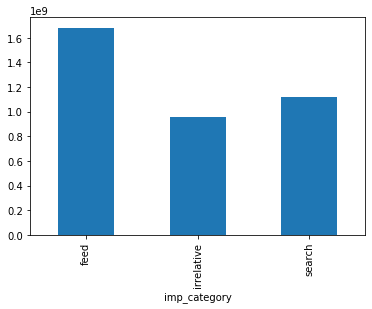

In [83]:
data.impression.plot(kind='bar')

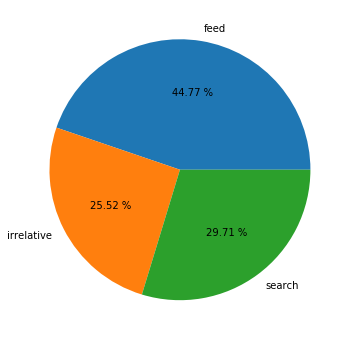

In [110]:
plt.figure(figsize=(6, 6))
fracs = data['dist%']
labels = ['feed', 'irrelative', 'search']
plt.pie(fracs, labels=labels, autopct='%.2f %%')
plt.show()

## Impression distribution per tile position drop exponentially with a flat and long tail. 

In [250]:
df_imp_epc_groupby_pos = df_imp_epc.groupby('pos')

In [251]:
data2 = pd.DataFrame(df_imp_epc_groupby_pos.impression.sum())
data2.reset_index(drop=False,inplace=True)
data2['overall_impression']=df_imp_epc.impression.sum()
data2['dist%'] = round(100*data2.impression/data2.overall_impression,2)
data2.head(10)

,pos,impression,overall_impression,dist%
0,0,108760715,3755419439,2.90
1,1,105247819,3755419439,2.80
2,2,101380920,3755419439,2.70
3,3,93590512,3755419439,2.49
4,4,54730555,3755419439,1.46
5,5,53280570,3755419439,1.42
6,6,42843539,3755419439,1.14
7,7,42072250,3755419439,1.12
8,8,36553280,3755419439,0.97
9,9,35682804,3755419439,0.95


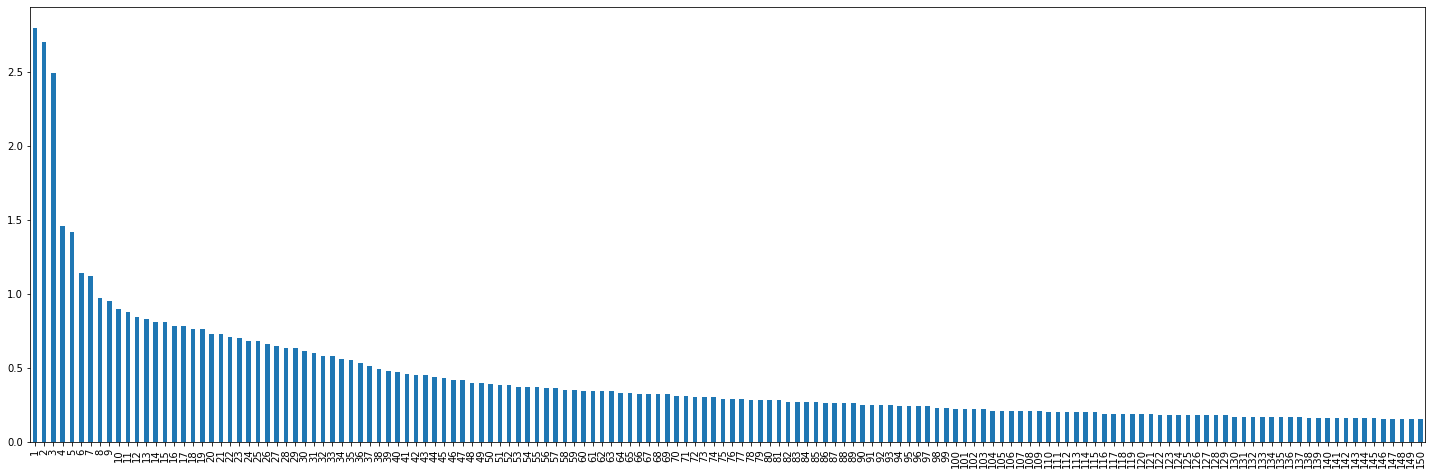

In [263]:
plt.figure(figsize=(25, 8))
mask = (data2['pos']>=1) & (data2['pos']<=150)
data2.loc[mask,'dist%'].plot(kind='bar')

In [260]:
data2['pos']

0            0
1            1
2            2
3            3
4            4
         ...  
16710    16735
16711    16736
16712    16737
16713    16738
16714    16739
Name: pos, Length: 16715, dtype: int64

# Step-4:Overall EPC impression analysis

### Within one day traffic, EPC product only shows on 49% of all impressions

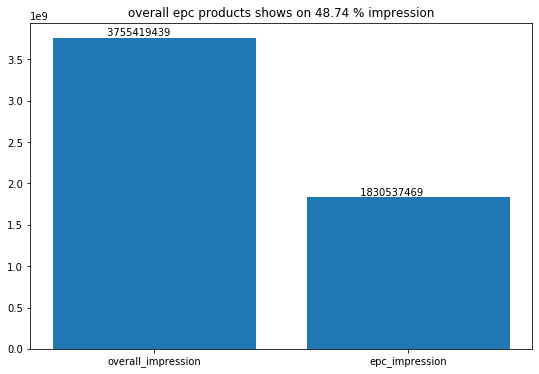

In [157]:
names = ["overall_impression","epc_impression"]
plt.figure(figsize=(9, 6))
plt.bar(names,[df_imp_epc.impression.sum(),df_imp_epc.epc_impression.sum()])
perc = str(round(100*df_imp_epc.epc_impression.sum()/df_imp_epc.impression.sum(),2))
plt.title('overall epc products shows on %s %% impression' %perc)
for i, v in enumerate([df_imp_epc.impression.sum(),df_imp_epc.epc_impression.sum()]):
    plt.text(i-0.2,v*1.01," "+str(v))
plt.show()

### Within one day traffic, there are 32% tiles do not show any EPC product in overal. 

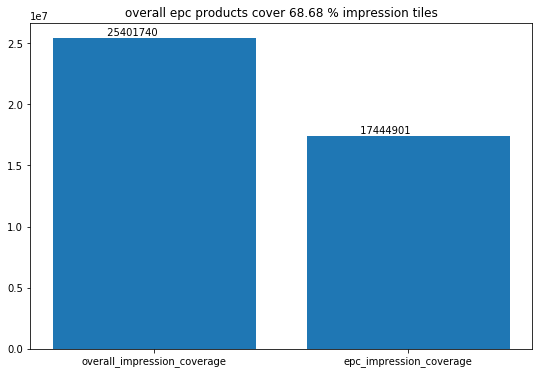

In [158]:
names = ["overall_impression_coverage","epc_impression_coverage"]
plt.figure(figsize=(9, 6))
plt.bar(names,[df_imp_epc.is_epc_covered.count(),df_imp_epc.is_epc_covered.sum()])
perc = str(round(100*df_imp_epc.is_epc_covered.sum()/df_imp_epc.is_epc_covered.count(),2))
plt.title('overall epc products cover %s %% impression tiles' %perc)
for i, v in enumerate([df_imp_epc.is_epc_covered.count(),df_imp_epc.is_epc_covered.sum()]):
    plt.text(i-0.2,v*1.01," "+str(v))
plt.show()

# Step-5: Further analysis by impression category

In [218]:
#data3 = pd.DataFrame({'overall_impression_coverage': df_imp_epc_groupby_imp_category.is_epc_covered.count()})
#data3.reset_index(drop=False, inplace=True)
#names = ['epc_impression_coverage','overall_impression','epc_impression']
#cols = ['is_epc_covered','impression','epc_impression']

#data['overall_impression']=df_imp_epc.impression.sum()

In [214]:
summary = df_imp_epc_groupby_imp_category.agg({"is_epc_covered" : ["count","sum"] ,
                                    'impression' : "sum",
                                    'epc_impression' : "sum"
                                    })
summary.columns = ['overall_impression_coverage','epc_impression_coverage','overall_impression','epc_impression']

In [219]:
summary['coverage%'] = round(100*summary.epc_impression_coverage/summary.overall_impression_coverage,2)
summary['impression%'] = round(100*summary.epc_impression/summary.overall_impression,2)
summary

,overall_impression_coverage,epc_impression_coverage,overall_impression,epc_impression,coverage%,impression%
imp_category,,,,,,
feed,20784897,13912617,1681295572,898263120,66.94,53.43
irrelative,2975785,2275955,958451387,487504084,76.48,50.86
search,1641058,1256329,1115672480,444770265,76.56,39.87


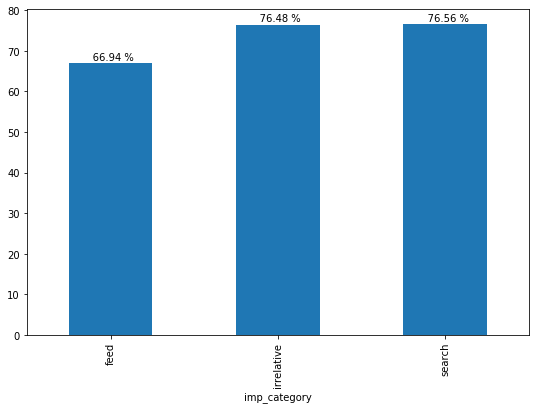

In [243]:
plt.figure(figsize=(9, 6))
summary['coverage%'].plot(kind='bar')
for i, v in enumerate(summary['coverage%']):
    plt.text(i-0.2,v*1.01," "*5+str(v)+' %')
plt.show()

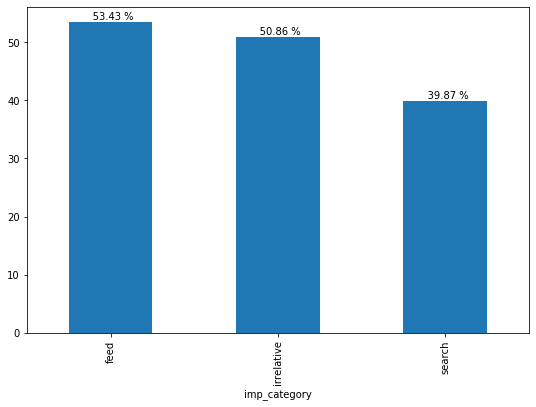

In [244]:
plt.figure(figsize=(9, 6))
summary['impression%'].plot(kind='bar')
for i, v in enumerate(summary['impression%']):
    plt.text(i-0.2,v*1.01," "*5+str(v)+' %')
plt.show()